# 读取数据并划分数据集

In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd

# 加载数据

# skiprows=1：跳过文件的第一行，通常是标题。
# usecols=(0, 1)：指定要加载的列，这里是第一列和第二列。
# converters={1: lambda x: x.decode('utf-8')}：指定对加载的第二列进行特定的转换，这里是将字节对象解码为 UTF-8 编码的字符串。
# converters 参数允许您对每一列的数据应用自定义的转换函数。
file_path = '../dataset/ml-latest-small/ratings.csv'
total_lines = sum(1 for line in open(file_path, encoding='utf-8'))
with tqdm(total=total_lines, desc=f'加载 {file_path}') as pbar:
    # 三千万个数据太大了，内存放不下，改成5000
    # 但是如果取5000还用大矩阵的话就太过稀疏了，所以改成small数据集
    data = pd.read_csv(file_path, usecols=(0, 1, 2), dtype=float, encoding='utf-8', converters=None).head(20000)
    pbar.update(len(data))
ratings_data = data.to_numpy()

file_path = '../dataset/ml-latest-small/movies.csv'
total_lines = sum(1 for line in open(file_path, encoding='utf-8'))
with tqdm(total=total_lines, desc=f'加载 {file_path}') as pbar:
    data = pd.read_csv(file_path, usecols=(0, 1), dtype=float, encoding='utf-8', converters={1: lambda x: x})
    pbar.update(len(data))
movies_data = data.to_numpy()

# 假设用户和电影的ID是连续的整数，可以使用unique来获取唯一的用户和电影ID
# 这个是评分矩阵维度的参数
user_ids = np.unique(ratings_data[:, 0])
movie_ids = np.unique(movies_data[:, 0])
users_num = user_ids.shape[0]
movies_num = movie_ids.shape[0]
iter_list = []
loss_list = []

# 打乱评分矩阵
np.random.seed(42)  # 设置随机种子以保持可重复性
np.random.shuffle(ratings_data)

# 划分数据集
train_size = int(0.8 * len(ratings_data))
val_size = test_size = (len(ratings_data) - train_size) // 2

train_data = ratings_data[:train_size]
val_data = ratings_data[train_size:train_size + val_size]
test_data = ratings_data[train_size + val_size:]

# 打印数据集大小
print("训练集大小:", len(train_data))
print("验证集大小:", len(val_data))
print("测试集大小:", len(test_data))

加载 ../dataset/ml-latest-small/movies.csv:   0%|                                             | 0/9743 [00:00<?, ?it/s]D:\python\anaconda\envs\PyTorch\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Both a converter and dtype were specified for column title - only the converter will be used
  return func(*args, **kwargs)
加载 ../dataset/ml-latest-small/movies.csv: 100%|█████████████████████████████▉| 9742/9743 [00:00<00:00, 884875.79it/s]

训练集大小: 16000
验证集大小: 2000
测试集大小: 2000


In [2]:
print(users_num, movies_num)
print(type(train_data[0][0]), type(movies_data[0][0]))
print('[', train_data[0][0], ',', train_data[0][1], ',',  train_data[0][2], ']')
print(train_data[0])
print(movies_data[-1])
print('-'*40)
print(train_data)
print('-'*40)
print(val_data)
print('-'*40)
print(test_data)
print('-'*40)
print(movies_data)

132 9742
<class 'numpy.float64'> <class 'float'>
[ 68.0 , 1729.0 , 3.0 ]
[  68. 1729.    3.]
[193609.0 'Andrew Dice Clay: Dice Rules (1991)']
----------------------------------------
[[6.80000e+01 1.72900e+03 3.00000e+00]
 [1.80000e+01 8.91700e+03 3.50000e+00]
 [5.90000e+01 1.22400e+03 5.00000e+00]
 ...
 [6.80000e+01 1.63000e+02 4.50000e+00]
 [1.05000e+02 1.34326e+05 4.50000e+00]
 [3.30000e+01 1.50000e+02 3.00000e+00]]
----------------------------------------
[[1.1000e+01 4.4000e+01 2.0000e+00]
 [1.2200e+02 5.2319e+04 4.5000e+00]
 [5.0000e+01 5.2180e+03 2.0000e+00]
 ...
 [2.9000e+01 8.2459e+04 5.0000e+00]
 [4.5000e+01 5.9400e+02 4.0000e+00]
 [2.8000e+01 5.6320e+03 3.0000e+00]]
----------------------------------------
[[2.200e+01 6.711e+03 4.000e+00]
 [6.800e+01 2.997e+03 4.500e+00]
 [4.200e+01 2.502e+03 5.000e+00]
 ...
 [3.800e+01 1.630e+02 1.000e+00]
 [6.000e+00 9.810e+02 3.000e+00]
 [1.030e+02 6.711e+03 5.000e+00]]
----------------------------------------
[[1.0 'Toy Story (1995)']
 [

# 进行奇异值分解并训练模型

In [3]:
# 构建评分矩阵，users_num行movies_num列，先全部填上NaN，把有评分的部分再做调整

def create_R(data_input):
    R = np.full((users_num, movies_num), np.nan)

    for rating in data_input:
        user_id, movie_id, rating_value = rating[0], rating[1], rating[2]
        row = user_id - 1
        column = np.where(movies_data[:, 0] == movie_id)[0]  # 找到电影的索引
        if len(column) > 0:
            column = column[0]
            R[int(row), int(column)] = rating_value

    return R

In [4]:
# 进行矩阵分解
def matrix_depart_bias(matrix_input, k=5, epochs=1000, lr=0.002, reg=0.02):
    # matrix_input 是输入的用户-物品评分矩阵
    # k是隐藏特征数量
    # epochs是训练轮数
    # lr是学习率
    # reg是正则化参数
    
    # 初始化参数
    num_users, num_items = matrix_input.shape
    epoch_loss = 0
    num_rate = 0

    # 随机初始化用户矩阵 P 和物品矩阵 Q
    P = np.random.rand(num_users, k)
    Q = np.random.rand(num_items, k)
    
    # 初始化用户和物品的偏置项
    user_bias = np.zeros(num_users)
    item_bias = np.zeros(num_items)
    global_bias = np.nanmean(matrix_input)   # 需要忽略NaN值

    # 训练模型
    for epoch in range(epochs):
        for i in range(num_users):
            for j in range(num_items):
                if not np.isnan(matrix_input[i][j]):
                    loss = matrix_input[i][j] - user_bias[i] - item_bias[j] - global_bias - np.dot(P[i], Q[j])
                    epoch_loss += loss ** 2
                    num_rate += 1
                    P[i] += lr * (2 * loss * Q[j] - 2 * reg * P[i])
                    Q[j] += lr * (2 * loss * P[i] - 2 * reg * Q[j])
                    user_bias[i] += lr * (2 * loss - 2 * reg * user_bias[i])
                    item_bias[j] += lr * (2 * loss - 2 * reg * item_bias[j])
        epoch_loss /= num_rate
        iter_list.append(epoch+1)
        loss_list.append(epoch_loss)
        
        if epoch == 0 or (epoch + 1) % 10 == 0:
            print('Epoch:', epoch+1, 'Loss:', epoch_loss)
        epoch_loss = 0
        num_rate = 0
        
    return P, Q, user_bias, item_bias, global_bias

In [5]:
# 根据训练好的参数完成预测矩阵
def predict(P, Q, user_bias, item_bias, global_bias):
    # 初始化参数
    num_users = P.shape[0]
    num_items = Q.shape[0]
    
    # 初始化一个与评分矩阵相同形状的矩阵，用于存储预测值
    predictions = np.zeros((num_users, num_items))

    # 遍历所有用户和物品的组合
    for i in range(num_users):
        for j in range(num_items):
            # 计算预测评分
            predictions[i, j] = user_bias[i] + item_bias[j] + global_bias + np.dot(P[i], Q[j])

    return predictions

In [6]:
# 用均方根误差进行评估
def evaluate(R, R_pred):
    # 初始化参数
    num_users, num_items = R.shape
    rmse = 0.0
    
    # 计算 RMSE
    num_ratings = 0
    for i in range(num_users):
        for j in range(num_items):
            if not np.isnan(R[i, j]):
                rmse += (R[i, j] - R_pred[i, j]) ** 2
                num_ratings += 1
    rmse = np.sqrt(rmse / num_ratings)

    return rmse

In [7]:
# 训练
matrix_train = create_R(train_data)
print('开始训练')
train_P, train_Q, train_user_bias, train_item_bias, train_global_bias = matrix_depart_bias(matrix_train)
print('训练结束')
P_pred = predict(train_P, train_Q, train_user_bias, train_item_bias, train_global_bias)

开始训练
Epoch: 1 Loss: 1.4263411832222304
Epoch: 10 Loss: 0.7655631862096296
Epoch: 20 Loss: 0.6953231427010018
Epoch: 30 Loss: 0.6439257625133671
Epoch: 40 Loss: 0.5948103420277618
Epoch: 50 Loss: 0.5439821482950192
Epoch: 60 Loss: 0.49278859303049055
Epoch: 70 Loss: 0.4449740992279182
Epoch: 80 Loss: 0.40338162704524627
Epoch: 90 Loss: 0.36871342228112325
Epoch: 100 Loss: 0.34026663305990135
Epoch: 110 Loss: 0.31689991096453163
Epoch: 120 Loss: 0.29754291410652706
Epoch: 130 Loss: 0.2813426128286165
Epoch: 140 Loss: 0.267651985055297
Epoch: 150 Loss: 0.2559807163087346
Epoch: 160 Loss: 0.24595103189530335
Epoch: 170 Loss: 0.23726665377326395
Epoch: 180 Loss: 0.2296922509530526
Epoch: 190 Loss: 0.22303947418580086
Epoch: 200 Loss: 0.2171568449837553
Epoch: 210 Loss: 0.2119220220353932
Epoch: 220 Loss: 0.20723572737959325
Epoch: 230 Loss: 0.2030169562035002
Epoch: 240 Loss: 0.19919921882882372
Epoch: 250 Loss: 0.19572760984691492
Epoch: 260 Loss: 0.19255652792646097
Epoch: 270 Loss: 0.189

In [8]:
# 验证集上进行验证
R_val = create_R(val_data)
rmse_val = evaluate(R_val, P_pred)
print("验证集上的均方误差为：", rmse_val)

验证集上的均方误差为： 1.126653868556443


In [10]:
# 测试集上测试
R_test = create_R(test_data)
rmse_test = evaluate(R_test, P_pred)
print("测试集上的均方误差为：", rmse_test)

测试集上的均方误差为： 1.1140100433846176


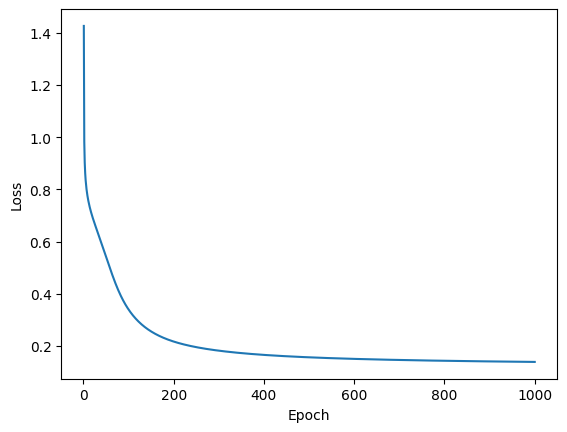

In [11]:
import matplotlib.pyplot as plt

plt.plot(iter_list, loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()